# Fitting of $n$-Dimensional PES

In this example we will consider 
$$
V(\boldsymbol{x}) = \boldsymbol{x}^\intercal \boldsymbol{A} \boldsymbol{x}
$$
where $\boldsymbol{A}$ satisfies $\det{\boldsymbol{A}}>0$.

<img src='assets/pompon-6d.svg' width=400>

## Environment 

In [1]:
import platform
import sys

import pompon

print(sys.version)
print(f"pompon version = {pompon.__version__}")
print(platform.platform())

3.12.2 (main, Feb  6 2024, 20:19:44) [Clang 15.0.0 (clang-1500.1.0.2.5)]
pompon version = 0.0.9
macOS-14.4.1-arm64-arm-64bit


## Import modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from pompon.utils import train_test_split

## Define the potential energy surface

In [3]:
# number of dimension
n = 6

A = np.diag(np.linspace(2.0, 5.0, n))
A += 1.0

print(f"A=\n{A}")
assert np.linalg.det(A) > 0

A=
[[3.  1.  1.  1.  1.  1. ]
 [1.  3.6 1.  1.  1.  1. ]
 [1.  1.  4.2 1.  1.  1. ]
 [1.  1.  1.  4.8 1.  1. ]
 [1.  1.  1.  1.  5.4 1. ]
 [1.  1.  1.  1.  1.  6. ]]


In [4]:
def ellipse_pes(x):
    if x.ndim == 2:
        return np.einsum("Da,ab,bD->D", x, A, x.T)
    else:
        return x @ (A @ x.T)

In [5]:
def ellipse_force(x):
    return -2.0 * x @ A

In [6]:
def plot_2d_cut(dims=(0, 1)):
    # cut of z
    q0 = np.linspace(-1, 1, 100)
    q1 = np.linspace(-1, 1, 100)
    Q0, Q1 = np.meshgrid(q0, q1)
    x = np.zeros((100 * 100, n))
    x[:, dims[0]] = Q0.flatten()
    x[:, dims[1]] = Q1.flatten()
    y = ellipse_pes(x).reshape(Q0.shape)
    plt.clf()
    plt.contourf(Q0, Q1, y, 50, cmap="RdGy", vmax=9, vmin=0)
    plt.xlabel(f"Q{dims[0]}")
    plt.ylabel(f"Q{dims[1]}")
    plt.title("2D-cut")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

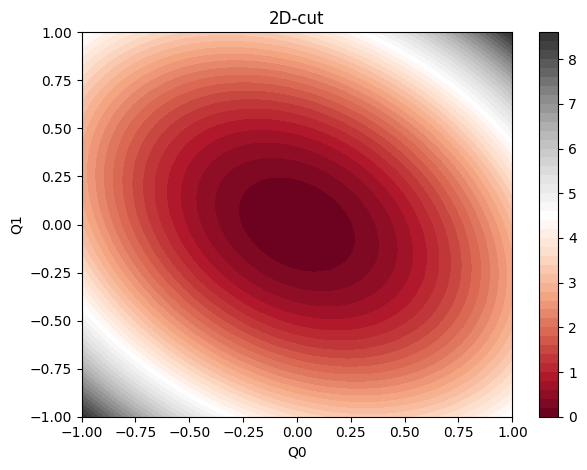

In [7]:
plot_2d_cut(dims=(0, 1))

## Sampling of learning points

Learning points are sampled from Boltzman distribution 
$\exp(-\beta V)$, which is anallytically achievable by using multivariate normal distribution.

In [8]:
def sample_ellipse(N=100, β=1.0e01):
    # sample from a 2D Gaussian
    np.random.seed(0)
    # Σ^-1 / 2 = A * β
    Σ = np.linalg.inv(A * β * 2.0)
    μ = np.zeros(A.shape[0])
    x = np.random.multivariate_normal(μ, Σ, N)
    return x

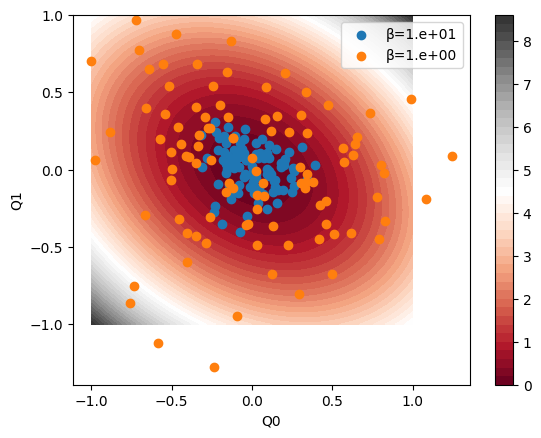

In [9]:
dims = (0, 1)
q0 = np.linspace(-1, 1, 100)
q1 = np.linspace(-1, 1, 100)
Q0, Q1 = np.meshgrid(q0, q1)
x = np.zeros((100 * 100, n))
x[:, dims[0]] = Q0.flatten()
x[:, dims[1]] = Q1.flatten()
y = ellipse_pes(x).reshape(Q0.shape)
plt.contourf(Q0, Q1, y, 50, cmap="RdGy", vmax=9, vmin=0)
plt.colorbar()
plt.xlabel(f"Q{dims[0]}")
plt.ylabel(f"Q{dims[1]}")


x = sample_ellipse(N=100, β=1.0e01)
plt.scatter(x[:, dims[0]], x[:, dims[1]], label="β=1.e+01")

x = sample_ellipse(N=100, β=1.0e00)
plt.scatter(x[:, dims[0]], x[:, dims[1]], label="β=1.e+00")
plt.legend()
plt.show()

One will sample $20n^2$ points with temperature $\beta=1.0$.

In [10]:
x = sample_ellipse(N=20 * (n**2), β=1.0e00)
y = ellipse_pes(x).reshape(-1, 1)
f = ellipse_force(x).reshape(-1, n)
x_train, x_test, y_train, y_test, f_train, f_test = train_test_split(
    x, y, f, train_size=0.7
)
print(x_train.shape)
print(y_train.shape)
print(f_train.shape)

(503, 6)
(503, 1)
(503, 6)


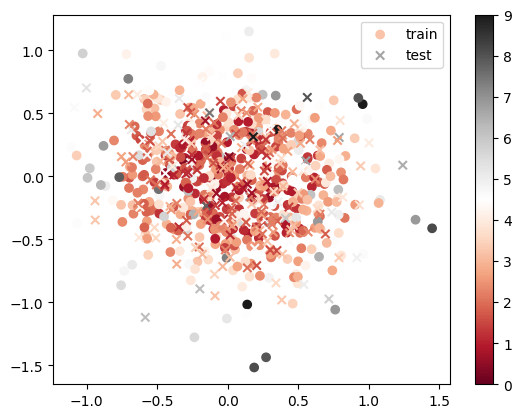

In [11]:
plt.scatter(
    x_train[:, 0],
    x_train[:, 1],
    c=y_train[:, 0],
    label="train",
    cmap="RdGy",
    vmax=9,
    vmin=0,
    marker="o",
)
plt.scatter(
    x_test[:, 0],
    x_test[:, 1],
    c=y_test[:, 0],
    label="test",
    cmap="RdGy",
    vmax=9,
    vmin=0,
    marker="x",
)
plt.colorbar()
plt.legend()
plt.show()

## Constructing the data & model

To stabilize the learning, one standardizes the input data.

In [12]:
x_scale = x_train.std()
x_train /= x_scale
x_test /= x_scale
y_shift = y_train.mean()
y_train -= y_shift
y_test -= y_shift
y_scale = y_train.std()
y_train /= y_scale
y_test /= y_scale
f_train *= x_scale / y_scale
f_test *= x_scale / y_scale

In [13]:
N = 20  # Number of basis per site
M = 1  # Initial Bond dimension
nnmpo = pompon.model.NNMPO(
    input_size=n,
    hidden_size=n,
    basis_size=N,
    bond_dim=M,
    activation="moderate+silu",
    b_scale=0.0,
    w_scale=1.0,
    x0=x_train[: N - 1],
)
# nnmpo.fix_bias=True

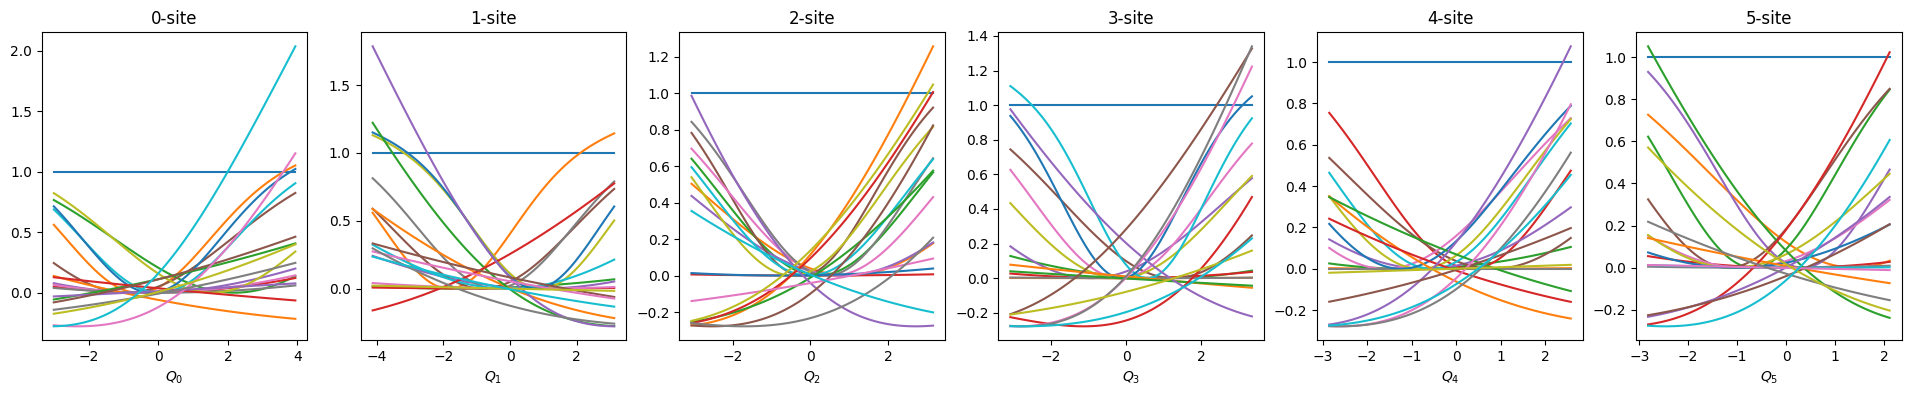

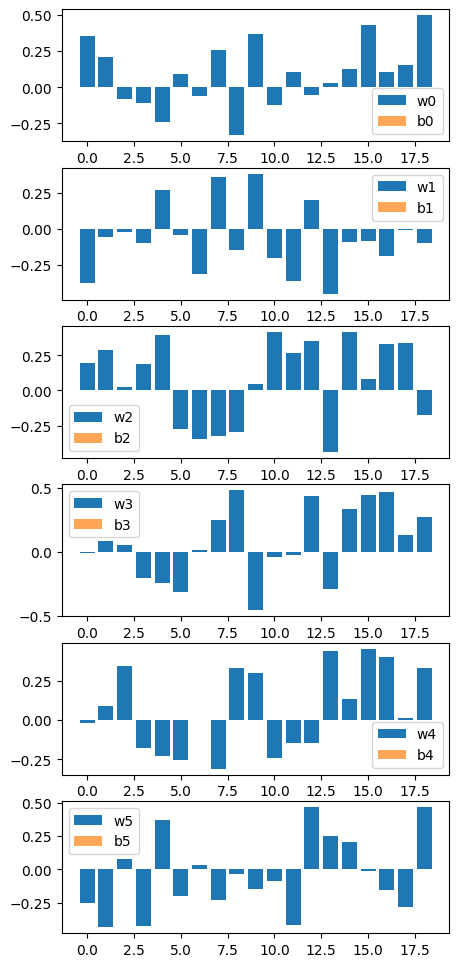

In [14]:
def show_basis(model):
    f = model.hidden_size
    fig, axs = plt.subplots(1, f, figsize=(4 * f, 4))
    q = model.coordinator.forward(x_train)
    q0 = model.q0
    for i in range(f):
        _q = np.linspace(np.min(q[:, i]), np.max(q[:, i]), 100)
        phi = model.basis[i].forward(_q, q0[:, i])
        axs[i].set_title(f"{i}-site")
        axs[i].set_xlabel(f"$Q_{i}$")
        axs[i].plot(_q, phi)
    plt.show()


show_basis(nnmpo)
nnmpo.basis.plot_data()

Construct model like this;

<img src='assets/pompon-6d.svg' width=400>

## Training

Let's start machine learning!

- `Adam`: Adam optimizer
- `lr`: learning rate $\eta$
- `batch_size`: Batch size for stochastic gradient descent.
- `epochs`: Number of iterations for optimizing $w$, $b$, and $U$.
- `nsweeps`: Number of sweeps
- `optax_solver`: Solver used for TT optimization
- `cutoff`: Singular value cutoff thereshold
- `maxdim`: Max bond dimension

We know that 
$$
V(\boldsymbol{x}) = \boldsymbol{x}^\intercal \boldsymbol{A} \boldsymbol{x}
$$
has 2-rank structure by diagonalizing $\boldsymbol{A}$, i.e.,
$$
V(\boldsymbol{x}) = \boldsymbol{x}^\intercal \boldsymbol{U} \boldsymbol{\Lambda} \boldsymbol{U}^\intercal \boldsymbol{x}
=
\boldsymbol{q}^\intercal \boldsymbol{\Lambda} \boldsymbol{q}
=
\begin{bmatrix}
1 & \lambda_1 q_1^2
\end{bmatrix}
\begin{bmatrix}
1 & \lambda_2 q_2^2 \\
0 & 1
\end{bmatrix}
\cdots
\begin{bmatrix}
1 & \lambda_{n-1} q_{n-1}^2 \\
0 & 1
\end{bmatrix}
\begin{bmatrix}
\lambda_n q_n^2 \\
1
\end{bmatrix}
$$

Thus, we set `maxdim=2`.

2024-10-16 10:37:11 - INFO:pompon.pompon.model - Model is exported to ./model_initial.h5


  0%|          | 0/200 [00:00<?, ?it/s]

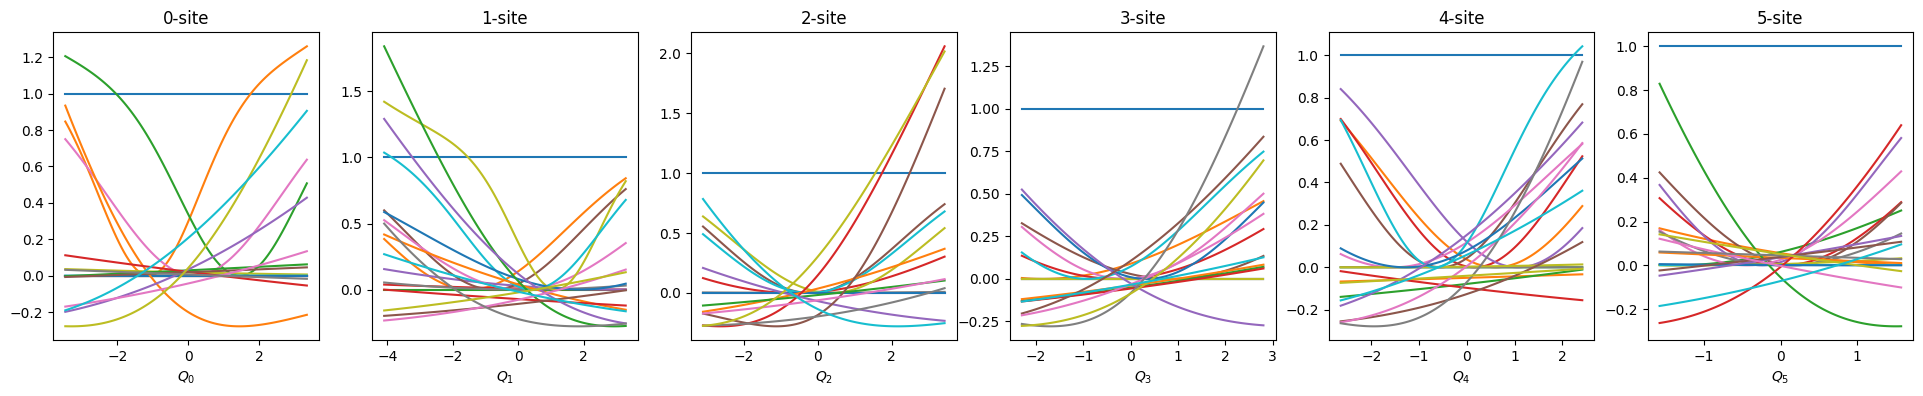

0it [00:00, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

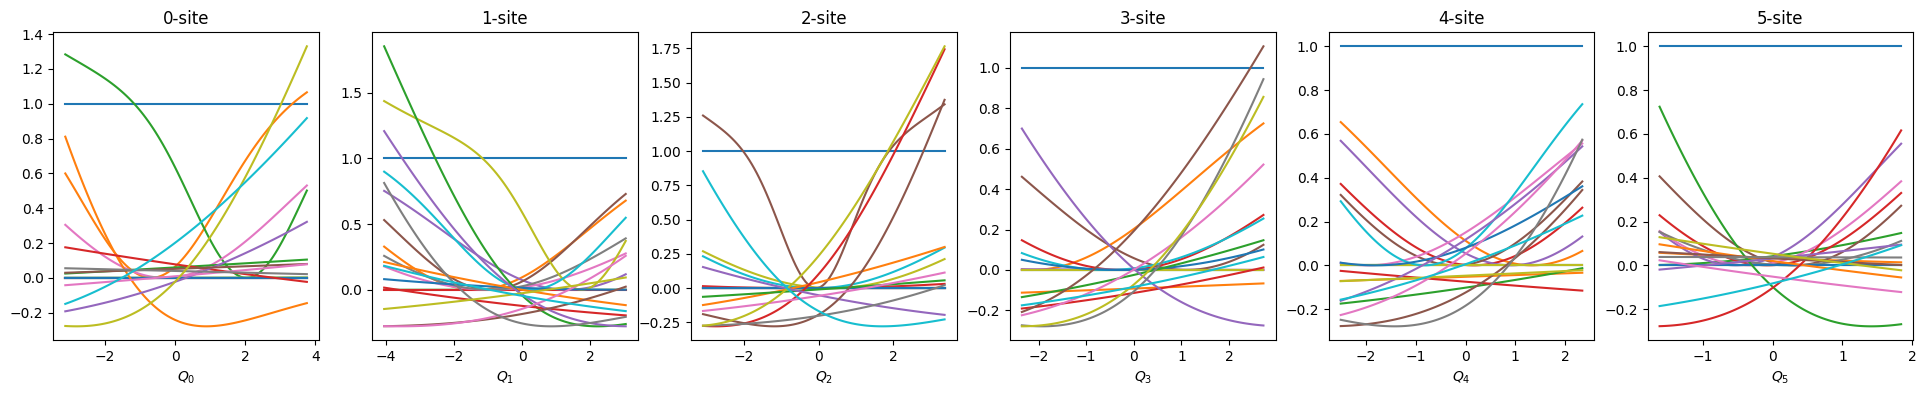

0it [00:00, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

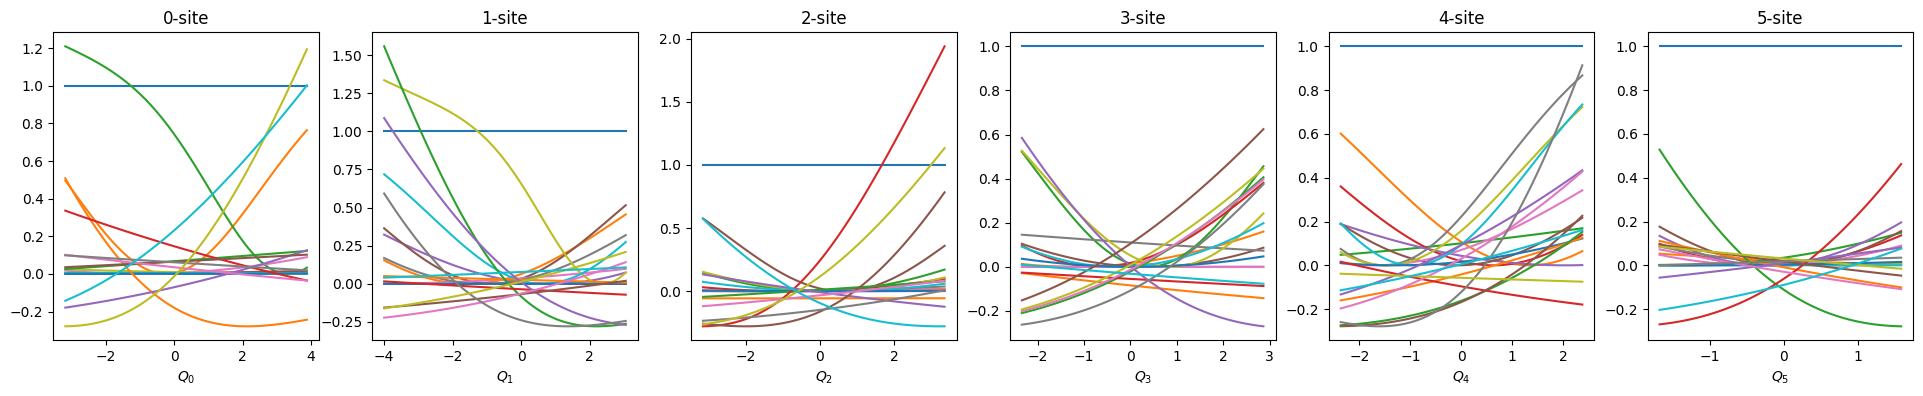

0it [00:00, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

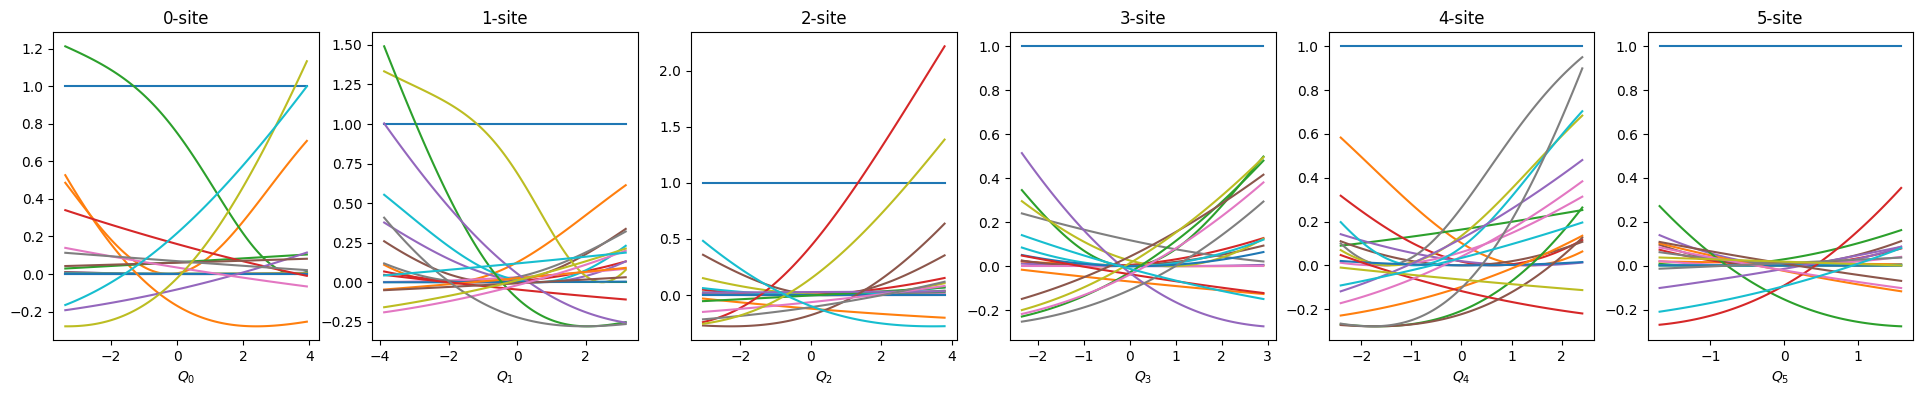

0it [00:00, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [15]:
import optax

from pompon.optimizer import Adam, Sweeper

optimizer = Adam(lr=1.0e-02).setup(
    model=nnmpo,
    x_train=x_train,
    y_train=y_train,
    f_train=f_train,
    batch_size=125,
    x_test=x_test,
    y_test=y_test,
)
sweeper = Sweeper(optimizer)
for i in range(4):
    trace = optimizer.optimize(
        epochs=200,
        epoch_per_log=200,
    )
    show_basis(nnmpo)
    trace = sweeper.sweep(
        nsweeps=4,
        optax_solver=optax.adam(1.0e-03),
        opt_batchsize=10000,
        opt_maxiter=1000,
        opt_tol=1.0e-03,
        cutoff=1.0e-01,
        maxdim=2,
        onedot=(i == 0),
        auto_onedot=True,
    )

# After adam, switch to conjugate gradient.
trace = sweeper.sweep(
    nsweeps=10,
    use_CG=True,
    opt_batchsize=10000,
    opt_maxiter=1000,
    opt_tol=1.0e-10,
    onedot=True,
)
optimizer.lr = 1.0e-05  # reduce learning rate
trace = optimizer.optimize(
    epochs=200,
    epoch_per_log=200,
)

## Results

In [16]:
trace

shape: (1_000, 6)
┌───────┬───────────┬──────────┬─────────────┬───────────┬─────────────┐
│ epoch ┆ mse_train ┆ mse_test ┆ mse_train_f ┆ tt_norm   ┆ tt_ranks    │
│ ---   ┆ ---       ┆ ---      ┆ ---         ┆ ---       ┆ ---         │
│ i64   ┆ f64       ┆ f64      ┆ f64         ┆ f64       ┆ list[i64]   │
╞═══════╪═══════════╪══════════╪═════════════╪═══════════╪═════════════╡
│ 1     ┆ 0.989216  ┆ 0.913552 ┆ 2.601824    ┆ 1.0       ┆ [1, 1, … 1] │
│ 2     ┆ 0.787074  ┆ 0.670019 ┆ 2.085504    ┆ 1.0       ┆ [1, 1, … 1] │
│ 3     ┆ 0.719287  ┆ 0.653636 ┆ 1.756305    ┆ 1.0       ┆ [1, 1, … 1] │
│ 4     ┆ 0.711022  ┆ 0.620294 ┆ 1.647353    ┆ 1.0       ┆ [1, 1, … 1] │
│ 5     ┆ 0.975683  ┆ 0.895574 ┆ 1.411286    ┆ 1.0       ┆ [1, 1, … 1] │
│ …     ┆ …         ┆ …        ┆ …           ┆ …         ┆ …           │
│ 996   ┆ 0.000035  ┆ 0.000074 ┆ 0.000101    ┆ -8.3396e7 ┆ [2, 2, … 2] │
│ 997   ┆ 0.000033  ┆ 0.000072 ┆ 0.000099    ┆ -8.3396e7 ┆ [2, 2, … 2] │
│ 998   ┆ 0.000038  ┆ 0.000076 ┆ 0.000102    ┆ -8.3396e7 ┆ [2, 2, … 2] │
│ 999   ┆ 0.000034  ┆ 0.000073 ┆ 0.0001      ┆ -8.3396e7 ┆ [2, 2, … 2] │
│ 1000  ┆ 0.000034  ┆ 0.000074 ┆ 0.000101    ┆ -8.3396e7 ┆ [2, 2, … 2] │
└───────┴───────────┴──────────┴─────────────┴───────────┴─────────────┘

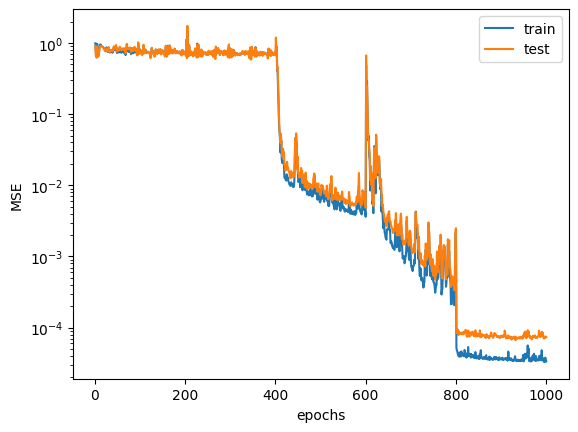

shape: (5, 6)
┌───────┬───────────┬──────────┬─────────────┬───────────┬─────────────┐
│ epoch ┆ mse_train ┆ mse_test ┆ mse_train_f ┆ tt_norm   ┆ tt_ranks    │
│ ---   ┆ ---       ┆ ---      ┆ ---         ┆ ---       ┆ ---         │
│ i64   ┆ f64       ┆ f64      ┆ f64         ┆ f64       ┆ list[i64]   │
╞═══════╪═══════════╪══════════╪═════════════╪═══════════╪═════════════╡
│ 996   ┆ 0.000035  ┆ 0.000074 ┆ 0.000101    ┆ -8.3396e7 ┆ [2, 2, … 2] │
│ 997   ┆ 0.000033  ┆ 0.000072 ┆ 0.000099    ┆ -8.3396e7 ┆ [2, 2, … 2] │
│ 998   ┆ 0.000038  ┆ 0.000076 ┆ 0.000102    ┆ -8.3396e7 ┆ [2, 2, … 2] │
│ 999   ┆ 0.000034  ┆ 0.000073 ┆ 0.0001      ┆ -8.3396e7 ┆ [2, 2, … 2] │
│ 1000  ┆ 0.000034  ┆ 0.000074 ┆ 0.000101    ┆ -8.3396e7 ┆ [2, 2, … 2] │
└───────┴───────────┴──────────┴─────────────┴───────────┴─────────────┘

In [17]:
plt.plot(trace["epoch"], trace["mse_train"], label="train")
plt.plot(trace["epoch"], trace["mse_test"], label="test")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()
plt.show()
trace.tail()

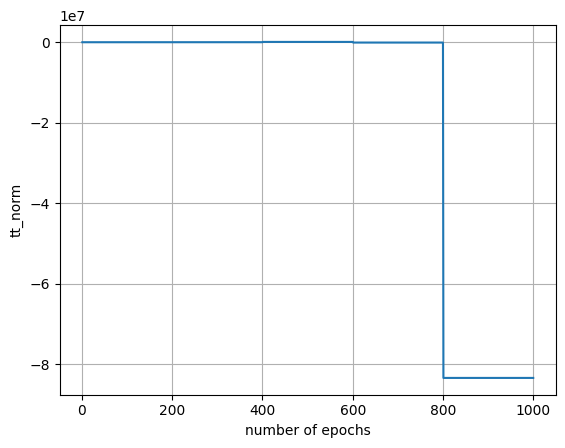

In [18]:
plt.plot(trace["epoch"], trace["tt_norm"])
plt.xlabel("number of epochs")
plt.ylabel("tt_norm")
plt.grid()
plt.show()

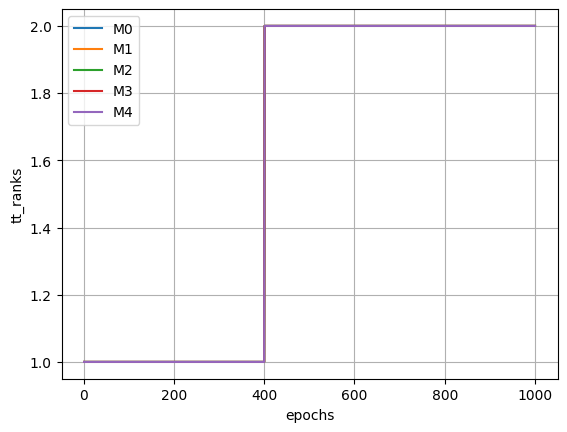

In [19]:
plt.plot(
    trace["epoch"],
    trace["tt_ranks"].to_list(),
    label=[f"M{i}" for i in range(n - 1)],
)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("tt_ranks")
plt.grid()
plt.show()

## Visualize 2D cut along equilibrium geometry

Before visualizing, we rescale model parameters to be consistent with the original scale because we trained with standardized data.

In [20]:
nnmpo.rescale(x_scale, y_scale)

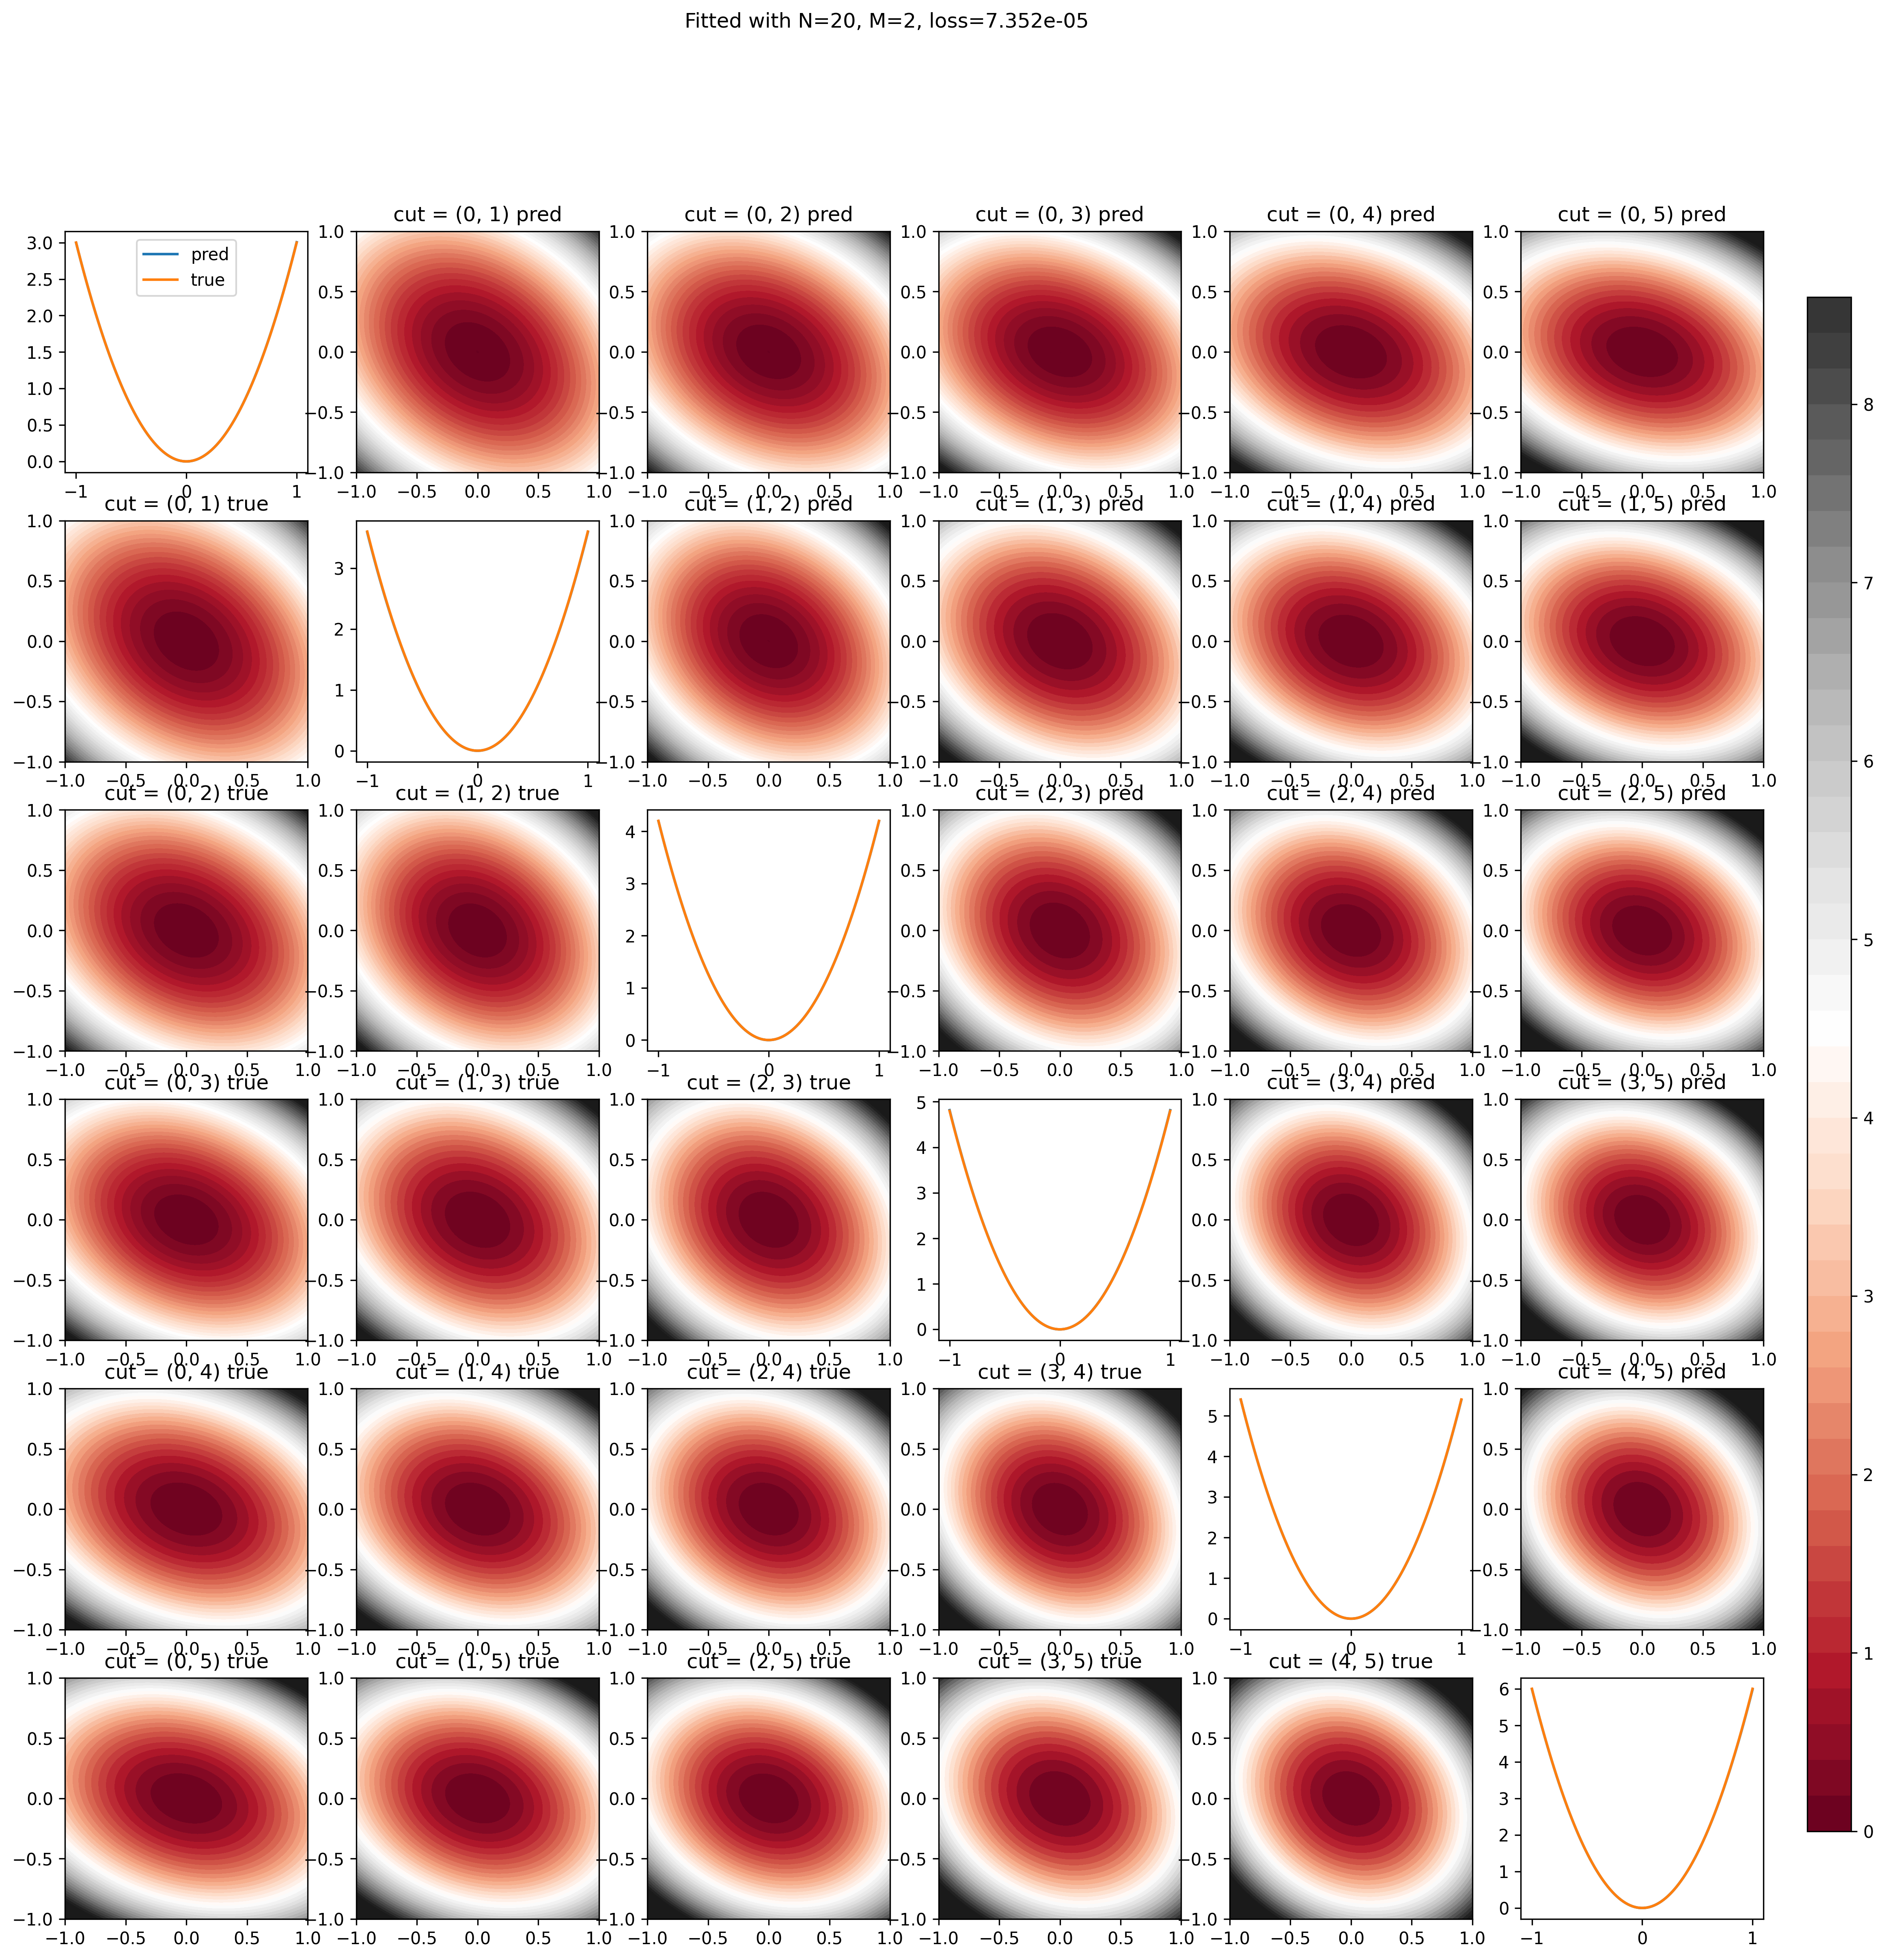

In [21]:
import itertools

q0 = np.linspace(-1, 1, 100)
q1 = np.linspace(-1, 1, 100)
Q0, Q1 = np.meshgrid(q0, q1)

fig, ax = plt.subplots(n, n, figsize=(3 * n, 3 * n), dpi=300)
x = np.zeros((100 * 100, n))
x[:, 0] = Q0.flatten()
x[:, 1] = Q1.flatten()
y = ellipse_pes(x).reshape(Q0.shape)
im = ax[0, 0].contourf(Q0, Q1, y, 50, cmap="RdGy", vmax=9, vmin=0)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
for dims in itertools.combinations(range(n), 2):
    x = np.zeros((100 * 100, n))
    x[:, dims[0]] = Q0.flatten()
    x[:, dims[1]] = Q1.flatten()
    y = nnmpo.forward(x).reshape(Q0.shape) + y_shift
    title = f"cut = {dims} pred"
    ax[dims[0], dims[1]].set_title(title)
    im = ax[dims[0], dims[1]].contourf(
        Q0, Q1, y, 50, cmap="RdGy", vmax=9, vmin=0
    )
for dims in itertools.combinations(range(n), 2):
    x = np.zeros((100 * 100, n))
    x[:, dims[0]] = Q0.flatten()
    x[:, dims[1]] = Q1.flatten()
    y = ellipse_pes(x).reshape(Q0.shape)
    title = f"cut = {dims} true"
    ax[dims[1], dims[0]].set_title(title)
    im = ax[dims[1], dims[0]].contourf(
        Q0, Q1, y, 50, cmap="RdGy", vmax=9, vmin=0
    )
for dim in range(n):
    ax[dim, dim].clear()
    x = np.zeros((100 * 1, n))
    x[:, dim] = q0
    y = nnmpo.forward(x).reshape(-1) + y_shift
    label = "pred" if dim == 0 else None
    ax[dim, dim].plot(q0, y, label=label)
    y = ellipse_pes(x).reshape(-1)
    label = "true" if dim == 0 else None
    ax[dim, dim].plot(q0, y, label=label)
    if dim == 0:
        ax[dim, dim].legend()

title = (
    f"Fitted with N={N}, M={max(trace['tt_ranks'][-1])}, "
    + f"loss={trace['mse_test'][-1]:.3e}"
)
fig.suptitle(title)
plt.savefig("data/6d_pes.png")
plt.show()

Visualize learning paramter. (chech over fitting occurs or not)

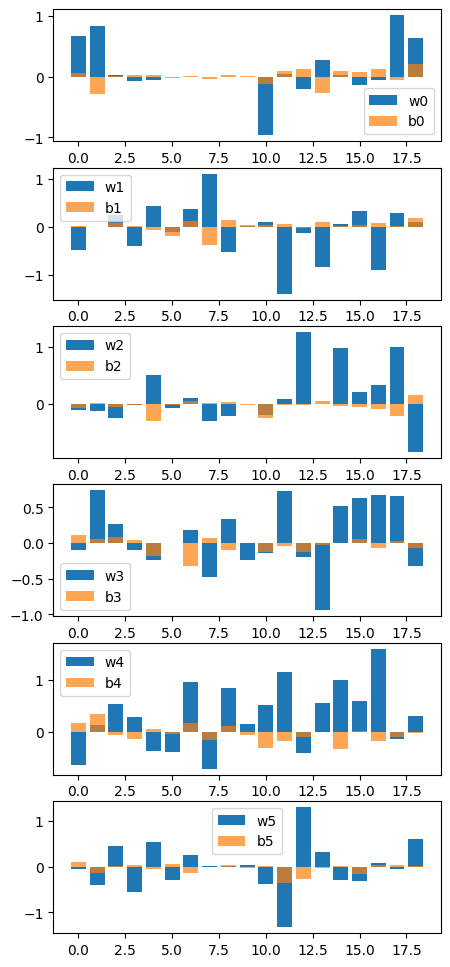

In [22]:
nnmpo.basis.plot_data()

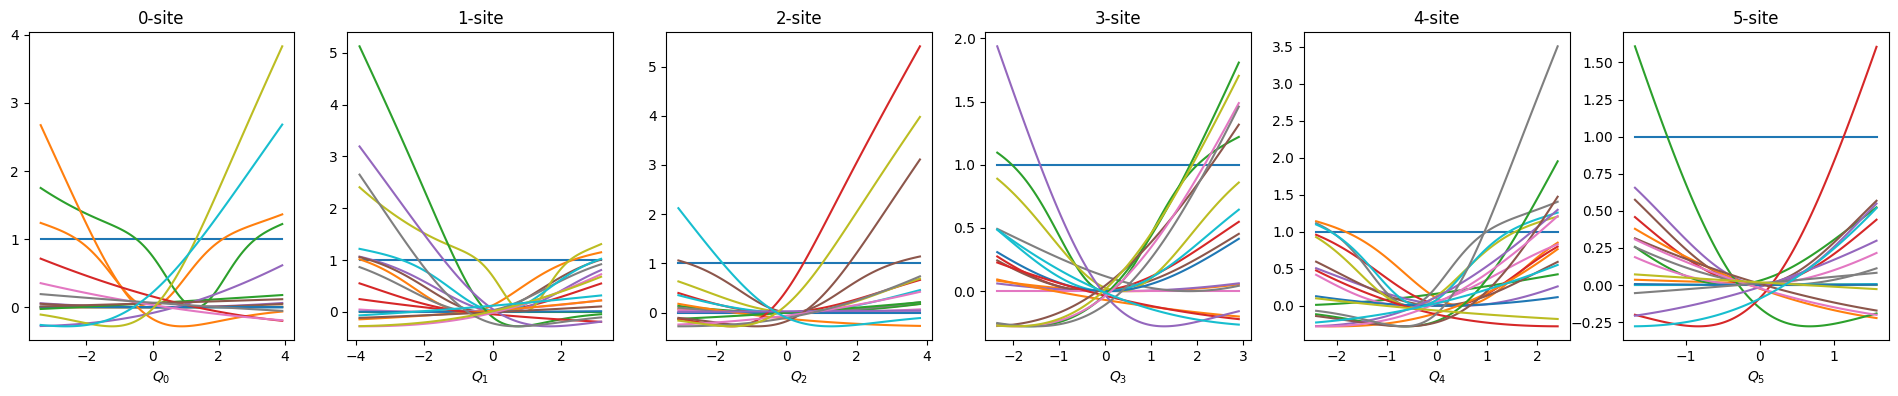

In [23]:
show_basis(nnmpo)